#Notebook: Audio Extraction
##Author: Lucía Núñez Calvo
###Date: 21/03/2024

####Summary
In this notebook the audio has been extracted from each video and stored in a directory system similar to the one that stores the videos. In this way, a quick association between the original video and the extracted audio is achieved.
The final lengths of each file are also shown to check if the audio has been extracted correctly.


####Structure of the notebook

0.   Installations
1.   Checking the directory system
2.   Audio extraction
3.   Checking the audio extraction




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from moviepy.editor import VideoFileClip
from collections import defaultdict
from graphviz import Digraph # To see the directory structure in a picture

import os
import logging # To minimise the output to the MoviePy console
import subprocess  # Required to execute FFmpeg commands
import pandas as pd
from pydub import AudioSegment

### 0. Installations

In [2]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [35]:
pip install pydub

### Checking the directory system

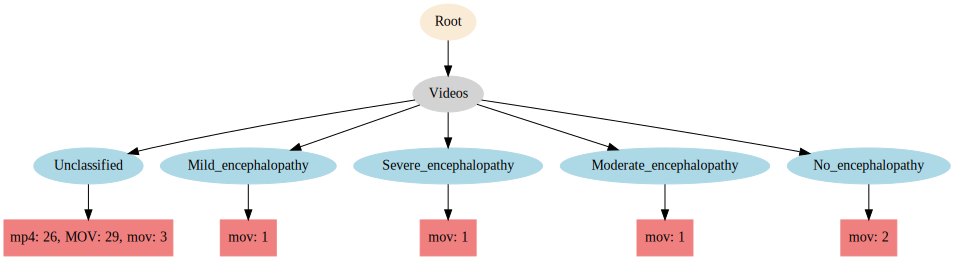

In [18]:
def display_directory(root, root_name='Root'):
    '''
    Function to visually present the directory system of the project.
    This function presents both directories and subdirectories, avoiding showing the files and showing only the number of files for each extension.

    Input:
      - root: (str) path of the root directory (Path of the folder containing the video clips).
      - root_name: (str) name to be displayed in the root node.
    Output: Dot object containing the complete directory structure.

    '''
    dot = Digraph()
    dot.node('Root', root_name, style='filled', color='antiquewhite')

    # Creating a set of colours for each level of the directory
    colors = ['lightgrey', 'lightblue', 'lightgreen']
    color_level = 0

    def new_directory(root, father_name, level=0):
        nonlocal color_level
        # Choose a colour according to the level of depth
        actual_color = colors[level % len(colors)]

        for d in os.listdir(root):
            path = os.path.join(root, d)
            node_name = f"{father_name}_{d}"

            if os.path.isdir(path):
                # Checks if it is a directory, if it is a directory creates a node
                dot.node(node_name, d, style='filled', color=actual_color)
                dot.edge(father_name, node_name)
                # Recursively calls the function
                new_directory(path, node_name, level+1)
            else:
                # If it's not a directory and it's files, ignore them
                continue

        # Count files by extension in the current directory.
        files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
        extensions = defaultdict(int)
        for f in files:
            ext = f.split('.')[-1]
            extensions[ext] += 1

        # Creates a node that summarises the file types and their quantity
        if files:
            all_files = ''
            for ext, count in extensions.items():
                if all_files:
                    all_files += ', '
                all_files += f"{ext}: {count}"

            dot.node(f"{father_name}_files", all_files, shape='box', style='filled', color='lightcoral')
            dot.edge(father_name, f"{father_name}_files")

    new_directory(root, 'Root')
    return dot

dot = display_directory('drive/MyDrive/TFM/', 'TFM')
dot.render('directory_system', format='png')
dot

### 2. Audio extraction
For audio extraction, a directory system has been created that is the same as the directory system containing the videos. In this way the audios can be easily related to the videos to which they belong because they have the same name but different extensions.


In [58]:
path = 'drive/MyDrive/TFM/'

# Creation of the 'Audios' directory
audio_path = os.path.join(path, 'Audios')
if not os.path.exists(audio_path):
    os.makedirs(audio_path)
    print('The Audios directory has been created correctly')
else:
  print('The directory Audios already exists')

The Audios directory has been created correctly


In [59]:
# Get all subdirectories in 'Videos'
video_dirs = [d for d in os.listdir(os.path.join(path, 'Videos')) if os.path.isdir(os.path.join(path, 'Videos', d))]

# Creation of the subdirectories of the directory 'Audios'
for dir in video_dirs:
    audio_subdir = os.path.join(audio_path, dir)
    if not os.path.exists(audio_subdir):
        os.makedirs(audio_subdir)
        print('Creation of the subdirectory: ', audio_subdir)

Creation of the subdirectory:  drive/MyDrive/TFM/Audios/Unclassified
Creation of the subdirectory:  drive/MyDrive/TFM/Audios/Mild_encephalopathy
Creation of the subdirectory:  drive/MyDrive/TFM/Audios/Severe_encephalopathy
Creation of the subdirectory:  drive/MyDrive/TFM/Audios/Moderate_encephalopathy
Creation of the subdirectory:  drive/MyDrive/TFM/Audios/No_encephalopathy


In [15]:
# To minimise the output to the MoviePy console
logging.getLogger('moviepy').setLevel(logging.ERROR)

# List of supported video extensions, although in this case more extensions appear here than we actually have,
#it is beneficial to be able to make a code that supports other video extensions in case more data is added in the future.
video_extensions = ['.mp4', '.mov', '.m4v', '.mkv', '.MOV']


def is_video(filename):
    '''
    Function to check if the file is a video
    Input:
      - filename: (str) - name of the file to be verified
    Output: (boolean) - True if the file has a video extension, False if it does not have a video extension
    '''
    return any(filename.endswith(ext) for ext in video_extensions)


def extract_audio_ffmpeg(video_path, audio_path):
    '''
    Function to extract audio using FFmpeg
    Input:
      - video_path: (str) - path of the video file from which the audio will be extracted
      - audio_path: (str) - path where the extracted audio file will be saved
    '''
    command = f'ffmpeg -i "{video_path}" -vn -acodec copy "{audio_path}"'
    subprocess.call(command, shell=True)


def process_videos_and_audios(video_base_path, audio_base_path):
    '''
    A function that processes the videos to extract the audio.
    The audio is extracted with MoviePy and in case it fails, try ffmpeg.
    Input:
      - video_base_path: (str) - path to the directory containing the video
      - video_base_path: (str) - path to the directory that holds the audio file
    '''
    for subdir in os.listdir(video_base_path):
        current_video_path = os.path.join(video_base_path, subdir)
        current_audio_path = os.path.join(audio_base_path, subdir)

        for filename in os.listdir(current_video_path):
            if is_video(filename):
                video_path = os.path.join(current_video_path, filename)
                audio_filename = os.path.splitext(filename)[0] + '.wav'
                audio_path = os.path.join(current_audio_path, audio_filename)

                # Checking to avoid reprocessing files
                if not os.path.exists(audio_path):
                    try:
                        video = VideoFileClip(video_path)
                        video.audio.write_audiofile(audio_path)
                        video.close()
                    except Exception as e:
                        print(f'Error with MoviePy when processing the file {filename}, trying with FFmpeg: {e}')
                        #extract_audio_ffmpeg(video_path, audio_path)
                        success = extract_audio_ffmpeg(video_path, audio_path)
                        if success:
                            print("Successful audio extraction with FFmpeg")
                        else:
                            print("Audio extraction with FFmpeg failed")
path = 'drive/MyDrive/TFM/'
video_base_path = os.path.join(path, 'Videos')
audio_base_path = os.path.join(path, 'Audios')

process_videos_and_audios(video_base_path, audio_base_path)

MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/39ae6684-c030-4008-ba0c-05551075d2bb.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/47f38257-5a56-4814-b569-54d1c217719e.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/0c84b92c-9996-4970-bece-10680196d8d9.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/0887b999-d13d-4234-b8ef-c28e93977198.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/1181fa2b-8916-45d7-8009-ab2784701b54.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/2d54d51a-4e2d-4538-9cba-38dde7866fee.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/097e9d10-cd40-42b4-aad3-9a497eef1c00.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/3aadd8c0-e7a4-48c2-b36d-0be45257a728.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/15 días sano.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/19687e15-ce84-45ff-b297-868c8c86d123.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/6b21f241-19af-4031-ad2b-0c3c67da528c.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/4f51bd1f-ab28-4efb-ba18-771c6a52021a.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/4920a275-cdc5-4950-a782-f715ac57fe9b.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/8bfee8ab-06c3-454a-b096-a75b2036ae0c.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/9950d18e-d3a6-427e-b518-39ac7995d1c3.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/bee58c70-e0e0-4dca-9aa7-6be78600b9c6.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/7455c553-96ee-47ed-987e-57e7e163d224.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/a34bf8fe-7383-401f-9f2c-7fb3b96b908a.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/4b1ba263-b0d9-4576-8f60-2523dac01095.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/76f45f11-f143-4f52-872f-245df2cc1de0.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/Ejemplo no-letargia.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/c90fc377-59d7-40c6-85cd-b6ea1a870d10.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/c8f57eb5-a7ea-4ebd-acc4-cbf8e3e5d98c.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/e344c01e-d1ab-4d3d-9f3d-0e5f5083dcaf.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/Ejemplo posicion grabacion_2.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/ce4c23ad-5f06-4fb4-aa8c-e3aaf0386f15.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/caba7c3e-ad77-41ab-b8d7-019785b0e739.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_1983.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_0927.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_1838.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_1982.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2130.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2112.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_1837.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/f31eac9b-e8d0-4915-b25c-98fdb11380d7.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2841.wav


MoviePy - Done.


MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2843.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2842.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2136.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3055.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2829.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_2137.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3056.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3183.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3079.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3059.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3089.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3060.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_8908.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_8867.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_9428.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_3232.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_8487.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_8922.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/IMG_9979_272_A_JA_contención.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/CAU5h26022013.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/CAA1h04102012.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Unclassified/CAU1h26022012.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Severe_encephalopathy/ARAHIP_08062011_1hora.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/Moderate_encephalopathy/let.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/No_encephalopathy/no_let.wav


MoviePy - Done.
MoviePy - Writing audio in drive/MyDrive/TFM/Audios/No_encephalopathy/no_let2.wav


MoviePy - Done.


### 3. Checking the audio extraction

In [52]:
video_path = 'drive/MyDrive/TFM/Videos/'
audio_path = 'drive/MyDrive/TFM/Audios/'

# List for storing the results
data = []

def get_media_duration(path):
    '''
    This function calculates the duration of a video or audio file.
    Input:
      - path: (str)  - path to the directory containing the video or audio
    Output:
      - duration: (float) - file duration in seconds
    '''
    duration = None
    try:
        if path.lower().endswith(('.mp4', '.m4v', '.mov', '.MOV')):
            clip = VideoFileClip(path)
            duration = clip.duration
            clip.close()
        elif path.lower().endswith(('.wav', '.mp3')):
            audio = AudioSegment.from_file(path, format="mp3", parameters=["-loglevel", "panic"])
            duration = len(audio) / 1000.0
        return duration

    except Exception as e:
        print(f"Error in processing {path}: {e}")
        return duration


# Browse through the subdirectories and files in the 'Videos' directory
for subdir, dirs, files in os.walk(video_path):
    category = os.path.basename(subdir) # Subdirectory name as category
    for file in files:
        video_path = os.path.join(subdir, file)
        video_duration = get_media_duration(video_path) # Duration of the video

        # Check if the category and file exist in the dictionary
        if category not in data:
            data[category] = {}
        data[category][file] = {'Video_duration': video_duration}


# Browse through the subdirectories and files in the 'Audios' directory
for subdir, dirs, files in os.walk(audio_path):
    category = os.path.basename(subdir) # Subdirectory name as category
    for file in files:
        audio_path = os.path.join(subdir, file)
        audio_duration = get_media_duration(audio_path) # Duration of the audio

        # Find the audio that corresponds to the video, it will have the same name but different extension
        base_name = os.path.splitext(file)[0]
        video_file_names = [f for f in data.get(category, {}) if f.startswith(base_name)]
        for video_file_name in video_file_names:
            data[category][video_file_name]['Audio_duration'] = audio_duration


# Convert dictionary to DataFrame
all_data = []
for category, files in data.items():
    for file, durations in files.items():
        all_data.append({
            'Category': category,
            'File': file,
            'Video_duration': durations.get('Video_duration'),
            'Audio_duration': durations.get('Audio_duration')
        })

# Crear DataFrame
video_audio_duration = pd.DataFrame(all_data)
video_audio_duration.to_csv('video_audio_duration.csv')
video_audio_duration

,Category,File,Video_duration,Audio_duration
0,Unclassified,39ae6684-c030-4008-ba0c-05551075d2bb.mp4,317.42,317.42
1,Unclassified,47f38257-5a56-4814-b569-54d1c217719e.mp4,113.92,113.92
2,Unclassified,0c84b92c-9996-4970-bece-10680196d8d9.mp4,285.00,285.00
3,Unclassified,0887b999-d13d-4234-b8ef-c28e93977198.mp4,264.52,264.52
4,Unclassified,1181fa2b-8916-45d7-8009-ab2784701b54.mp4,237.96,237.96
...,...,...,...,...
58,Mild_encephalopathy,ARAHIP1H12082011.mov,340.08,340.08
59,Severe_encephalopathy,ARAHIP_08062011_1hora.mov,992.48,992.48
60,Moderate_encephalopathy,let.mov,90.70,90.70
61,No_encephalopathy,no_let.mov,89.40,89.40


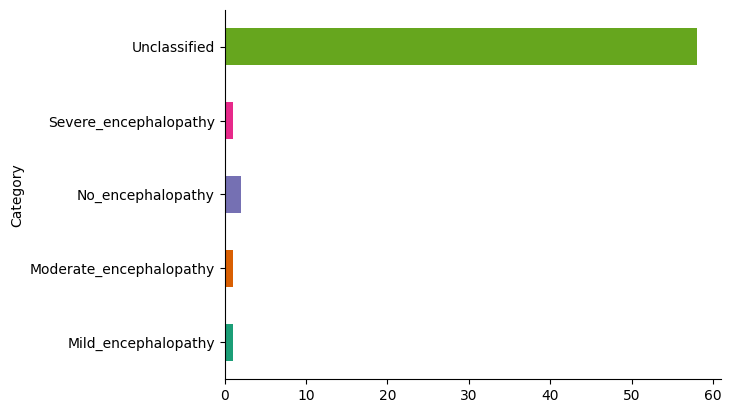

In [53]:
# @title Category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

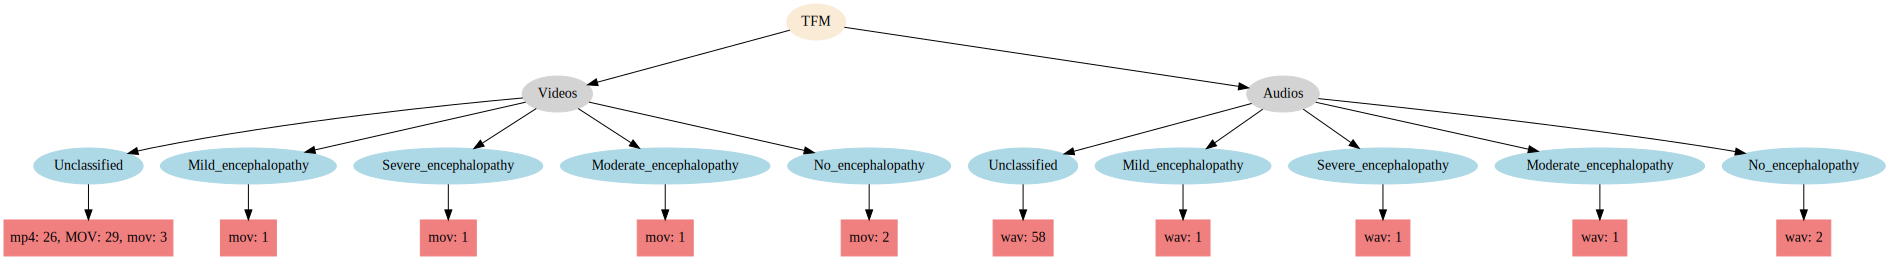

In [7]:
dot = display_directory('drive/MyDrive/TFM/', 'TFM')
dot.render('directory_system', format='png')
dot